<a href="https://www.kaggle.com/code/armanaghania/insulator-segmentation-with-u-net?scriptVersionId=140064509" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Install Dependencies

In [1]:
!pip install gitpython
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null

# Import Dependencies

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

import os
from PIL import Image, ImageDraw, ImageChops
from torch.utils.data import Dataset
import numpy as np

from glob import glob
import zipfile
import shutil

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.optim as optim

from torch.utils.data import DataLoader
import torchvision

from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import matplotlib.pyplot as plt
import cv2
import torchvision.transforms as transforms
import git

from torchvision.models import resnet50, ResNet50_Weights
import segmentation_models_pytorch as smp
import random

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Dataset

In [3]:
repository_url = "https://github.com/InsulatorData/InsulatorDataSet"
target_folder = "/kaggle/working/Insulator_dataset"
repo = git.Repo.clone_from(repository_url, target_folder)

In [4]:
class InsulatorDataset(Dataset):
  def __init__(
            self, 
            image_dir, 
            mask_dir, 
            transform=None, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,):
    self.image_dir = image_dir
    self.mask_dir  = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
    self.class_rgb_values = class_rgb_values

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    mask_path = os.path.join(self.mask_dir, self.images[index].replace('jpg', 'xml'))
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = parse_xml_masks(mask_path, image_size)


    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]


    return image, mask

In [5]:
image_size = (1152, 864)

# Test Train Split

In [6]:
os.mkdir('/kaggle/working/Insulator_dataset/Normal_Insulators/val')
os.mkdir('/kaggle/working/Insulator_dataset/Normal_Insulators/val_masks')

for file in sorted(os.listdir('/kaggle/working/Insulator_dataset/Normal_Insulators/images'))[:100]:
    shutil.move('/kaggle/working/Insulator_dataset/Normal_Insulators/images/' + file, '/kaggle/working/Insulator_dataset/Normal_Insulators/val')

for file in sorted(os.listdir('/kaggle/working/Insulator_dataset/Normal_Insulators/labels'))[:100]:
    shutil.move('/kaggle/working/Insulator_dataset/Normal_Insulators/labels/' + file, '/kaggle/working/Insulator_dataset/Normal_Insulators/val_masks')

In [7]:
os.mkdir('/kaggle/working/Insulator_dataset/Normal_Insulators/saved_images')

# Utils

In [8]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
  print("=> Saving Checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model):
  print("=> Loading Checkpoint")
  model.load_state_dict(checkpoint["state_dict"])

def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    batch_size,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True
):
  train_ds = InsulatorDataset(
      image_dir=train_dir,
      mask_dir=train_maskdir,
      transform=train_transform,
  )

  train_loader = DataLoader(
      train_ds,
      batch_size=batch_size,
      num_workers=num_workers,
      pin_memory=pin_memory,
      shuffle=True,
  )

  val_ds = InsulatorDataset(
      image_dir=val_dir,
      mask_dir=val_maskdir,
      transform=val_transform,

  )

  val_loader = DataLoader(
      val_ds,
      batch_size=batch_size,
      num_workers=num_workers,
      pin_memory=pin_memory,
      shuffle=False,
  )

  return train_loader, val_loader

def check_accuracy(loader, model, device="cuda"):
  num_correct = 0
  num_pixels = 0
  model.eval()

  with torch.no_grad():
    for x, y in loader:
      x = x.to(device)
      y = y.to(device).unsqueeze(1)
      preds = torch.sigmoid(model(x))
      preds = (preds > 0.5).float()
      num_correct += (preds == y).sum()
      num_pixels += torch.numel(preds)
      # dice_score += (2* (preds*y).sum()) / (
      #     (preds + y).sum() + 1e-8
      # )

    print(
        f"Got {num_correct}/{num_pixels} with acc {num_correct/num_pixels*100:.2f}"
    )

    # print(f"Dice Score: {dice_score/len(loader)}")

    model.train()



def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    model.eval()
    
    # Create the folder if it doesn't exist
    os.makedirs(folder, exist_ok=True)
    
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            
        # Convert the tensors to the appropriate data type (torch.uint8)
        preds = (preds * 255).to(torch.uint8)
        y = (y.unsqueeze(1) * 255).to(torch.uint8)
        
        # Convert tensors to numpy arrays and then save as images
        for i in range(preds.shape[0]):
            pred_img = preds[i].cpu().numpy()
            y_img = y[i].cpu().numpy()
            
            pred_path = os.path.join(folder, f"pred_{idx}_{i}.png")
            y_path = os.path.join(folder, f"{idx}_{i}.png")
            
            Image.fromarray(pred_img[0], mode='L').save(pred_path)
            Image.fromarray(y_img[0], mode='L').save(y_path)

#     model.train()
    
def parse_xml_masks(xml_path, image_size):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    # Create a new grayscale image
    mask = Image.new("L", image_size, 0)

    for obj in root.findall('object'):
        class_name = obj.find('name').text
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)

        # Make sure image_size is a tuple (height, width)
        height, width = image_size

        # Ensure that ymin, ymax, xmin, and xmax are within image bounds
#         ymin = max(0, ymin)
#         ymax = min(height, ymax)
#         xmin = max(0, xmin)
#         xmax = min(width, xmax)

        # Create a mask using ImageDraw
        draw = ImageDraw.Draw(mask)
        draw.rectangle([xmin, ymin, xmax, ymax], fill=255)

    # Convert the Image to a NumPy array
    mask_array = np.array(mask)
    mask_array[mask_array == 255] = 1.0  # Convert pixel values to 1.0

    return mask_array

def evaluate(loader, model, loss_fn, device):
    model.eval()
    total_loss = 0.0
    num_samples = 0

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device=device)
            targets = targets.float().unsqueeze(1).to(device=device)

            predictions = model(data)
            loss = loss_fn(predictions, targets)

            total_loss += loss.item() * data.size(0)
            num_samples += data.size(0)

    average_loss = total_loss / num_samples
    return average_loss

# Hyperparameters


In [9]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 3
NUM_WORKERS = 2
IMAGE_HEIGHT = 576
IMAGE_WIDTH = 448
PIN_MEMORY = True
LOAD_MODEL = False
TRAIN_IMG_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/images'
TRAIN_MASK_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/labels'
VAL_IMG_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/val'
VAL_MASK_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/val_masks'

# Train Model on Dataset to get a Checkpoint

In [10]:
 torch.cuda.empty_cache()

In [11]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
        
    return loss.item()

def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
#             A.RandomResizedCrop(IMAGE_HEIGHT, IMAGE_WIDTH),  # Add random resized crop
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Add color jitter,
            A.Normalize(
#                 mean=[0.0, 0.0, 0.0],
#                 std=[1.0, 1.0, 1.0],
                mean=[0.485, 0.456, 0.406],  # Imagenet normalization values
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
#                 mean=[0.0, 0.0, 0.0],
#                 std=[1.0, 1.0, 1.0],
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = smp.Unet('resnet50', encoder_weights='imagenet').to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)  # Reduce LR by half every epoch

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)


    # check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="saved_images/", device=DEVICE
        )
        
        val_loss = evaluate(val_loader, model, loss_fn, device=DEVICE)  # Implement a separate evaluation function
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {loss:.4f} - Val Loss: {val_loss:.4f}")
#         scheduler.step()  # Step the learning rate scheduler
        
        torch.cuda.empty_cache()

if __name__ == "__main__":
    main()

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 63.9MB/s]
100%|██████████| 63/63 [00:29<00:00,  2.12it/s, loss=0.309]


=> Saving Checkpoint
Got 23823114/25804800 with acc 92.32
Epoch [1/3] - Train Loss: 0.3087 - Val Loss: 0.3154


100%|██████████| 63/63 [00:23<00:00,  2.66it/s, loss=0.109]


=> Saving Checkpoint
Got 23602304/25804800 with acc 91.46
Epoch [2/3] - Train Loss: 0.1093 - Val Loss: 0.2124


100%|██████████| 63/63 [00:23<00:00,  2.66it/s, loss=0.108]


=> Saving Checkpoint
Got 23918065/25804800 with acc 92.69
Epoch [3/3] - Train Loss: 0.1081 - Val Loss: 0.1811


# Loading Checkpoint and Training Model for More Epochs

In [12]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 5
NUM_WORKERS = 2
IMAGE_HEIGHT = 576
IMAGE_WIDTH = 448
PIN_MEMORY = True
LOAD_MODEL = True
TRAIN_IMG_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/images'
TRAIN_MASK_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/labels'
VAL_IMG_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/val'
VAL_MASK_DIR = '/kaggle/working/Insulator_dataset/Normal_Insulators/val_masks'

In [13]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())
        
    return loss.item()

def main():
    train_transform = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Rotate(limit=35, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
#             A.RandomResizedCrop(IMAGE_HEIGHT, IMAGE_WIDTH),  # Add random resized crop
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Add color jitter,
            A.Normalize(
#                 mean=[0.0, 0.0, 0.0],
#                 std=[1.0, 1.0, 1.0],
                mean=[0.485, 0.456, 0.406],  # Imagenet normalization values
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    val_transforms = A.Compose(
        [
            A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
            A.Normalize(
#                 mean=[0.0, 0.0, 0.0],
#                 std=[1.0, 1.0, 1.0],
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )

    model = smp.Unet('resnet50', encoder_weights='imagenet').to(DEVICE)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#     scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)  # Reduce LR by half every epoch

    train_loader, val_loader = get_loaders(
        TRAIN_IMG_DIR,
        TRAIN_MASK_DIR,
        VAL_IMG_DIR,
        VAL_MASK_DIR,
        BATCH_SIZE,
        train_transform,
        val_transforms,
        NUM_WORKERS,
        PIN_MEMORY,
    )

    if LOAD_MODEL:
        load_checkpoint(torch.load("/kaggle/working/my_checkpoint.pth.tar"), model)
#         model = torch.hub.load("pytorch/vision", "resnet50", weights="IMAGENET1K_V2")
#         model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2).to(DEVICE)


    check_accuracy(val_loader, model, device=DEVICE)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(NUM_EPOCHS):
        loss = train_fn(train_loader, model, optimizer, loss_fn, scaler)

        # save model
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)

        # check accuracy
        check_accuracy(val_loader, model, device=DEVICE)

        # print some examples to a folder
        save_predictions_as_imgs(
            val_loader, model, folder="saved_images/", device=DEVICE
        )
        
        val_loss = evaluate(val_loader, model, loss_fn, device=DEVICE)  # Implement a separate evaluation function
        print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] - Train Loss: {loss:.4f} - Val Loss: {val_loss:.4f}")
#         scheduler.step()  # Step the learning rate scheduler
        
        torch.cuda.empty_cache()

if __name__ == "__main__":
    main()

=> Loading Checkpoint
Got 23918065/25804800 with acc 92.69


100%|██████████| 63/63 [00:23<00:00,  2.63it/s, loss=0.275]


=> Saving Checkpoint
Got 24291939/25804800 with acc 94.14
Epoch [1/5] - Train Loss: 0.2753 - Val Loss: 0.2240


100%|██████████| 63/63 [00:23<00:00,  2.64it/s, loss=0.1]


=> Saving Checkpoint
Got 24512338/25804800 with acc 94.99
Epoch [2/5] - Train Loss: 0.1003 - Val Loss: 0.1325


100%|██████████| 63/63 [00:23<00:00,  2.66it/s, loss=0.0976]


=> Saving Checkpoint
Got 24678249/25804800 with acc 95.63
Epoch [3/5] - Train Loss: 0.0976 - Val Loss: 0.1113


100%|██████████| 63/63 [00:23<00:00,  2.68it/s, loss=0.105]


=> Saving Checkpoint
Got 24402989/25804800 with acc 94.57
Epoch [4/5] - Train Loss: 0.1054 - Val Loss: 0.1390


100%|██████████| 63/63 [00:23<00:00,  2.68it/s, loss=0.0932]


=> Saving Checkpoint
Got 24762657/25804800 with acc 95.96
Epoch [5/5] - Train Loss: 0.0932 - Val Loss: 0.1028


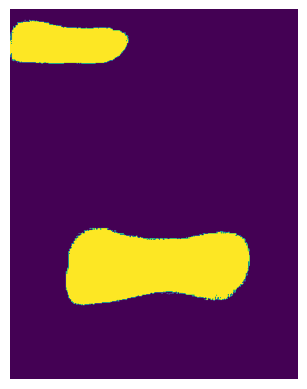

In [14]:
image = Image.open('/kaggle/working/saved_images/pred_0_4.png')
plt.imshow(image)
plt.axis("off")  # Turn off axis labels and ticks
plt.show()

# Loading Model to Evaluate

In [15]:
model = smp.Unet('resnet50', encoder_weights='imagenet').to(DEVICE)  # Replace with your model initialization
model.load_state_dict(torch.load("my_checkpoint.pth.tar")["state_dict"])
model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

# Testing Model on Unseen Data by the Model

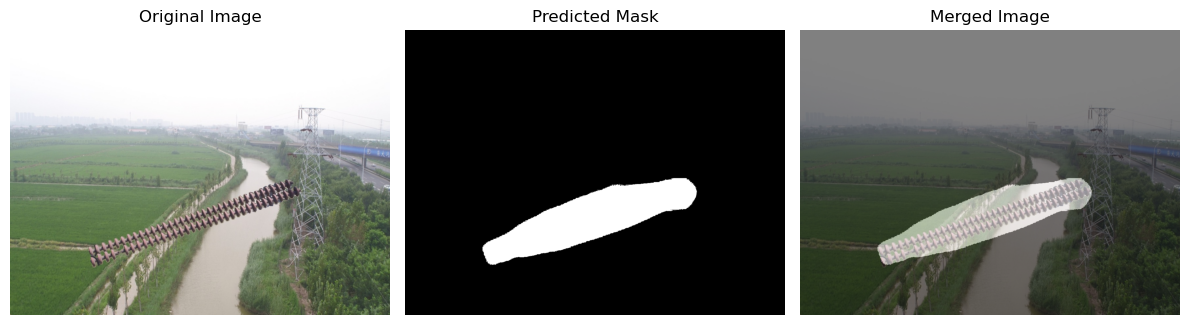

In [16]:
# Load and preprocess the new image
new_image_path = "/kaggle/working/Insulator_dataset/Defective_Insulators/images/121.jpg"  # Update the path
new_image = Image.open(new_image_path)
transform = transforms.Compose([
#     transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])])
new_image_tensor = transform(new_image).unsqueeze(0).to(DEVICE)

# Make predictions
with torch.no_grad():
    preds = model(new_image_tensor)
    preds = torch.sigmoid(preds)
    binary_preds = (preds > 0.5).float()

# Convert the tensor predictions to a NumPy array
binary_preds_np = binary_preds.squeeze().cpu().numpy()

# Display the original image and the predicted mask

plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(np.array(new_image))
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(binary_preds_np, cmap="gray")
plt.title("Predicted Mask")
plt.axis("off")

# Merged Image with Mask
plt.subplot(1, 3, 3)
plt.imshow(np.array(new_image))
plt.imshow(binary_preds_np, cmap="gray", alpha=0.5)  # Adjust alpha value as needed
plt.title("Merged Image")
plt.axis("off")


plt.tight_layout()
plt.show()